In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Function to normalise the train data
def normalize_the_data(flare_data):
  median = []
  std = []
  flare_data = np.array(flare_data)
  n_elements = flare_data.shape[0]
  for j in range(flare_data.shape[1]):
    standard_deviation_of_this_feature = np.std(flare_data[:, j])
    std.append(standard_deviation_of_this_feature)
    median_of_this_feature = np.median(flare_data[:, j])
    median.append(median_of_this_feature)
    for i in range(n_elements):
      flare_data[i, j] = (
        flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
  return flare_data, median, std

# Function to normalise the test data using the median and the std of the train data
def transform(data, median, std):
  flare_data = np.array(data)
  n_elements = flare_data.shape[0]
  for j in range(flare_data.shape[1]):
    for i in range(n_elements):
      flare_data[i, j] = (
        flare_data[i, j] - median[j]) / (std[j])
  return flare_data

In [21]:
def confusion_table(pred, labels):
    """
    computes the number of TP, TN, FP, FN events given the arrays with predictions and true labels
    and returns the true skill score

    Args:
    pred: np array with predictions (1 for flare, 0 for nonflare)
    labels: np array with true labels (1 for flare, 0 for nonflare)

    Returns: true negative, false positive, true positive, false negative
    """
    Nobs = len(pred)
    TN = 0.
    TP = 0.
    FP = 0.
    FN = 0.
    for i in range(Nobs):
        if (pred[i] == 0 and labels[i] == 0):
            TN += 1
        elif (pred[i] == 1 and labels[i] == 0):
            FP += 1
        elif (pred[i] == 1 and labels[i] == 1):
            TP += 1
        elif (pred[i] == 0 and labels[i] == 1):
            FN += 1
        else:
            print("Error! Observation could not be classified.")
    return TN, FP, TP, FN

In [22]:
def TSS_score(y_true, y_pred):
  TN, FP, TP, FN = confusion_table(y_pred, y_true)
  if ((TP+FN) == 0.0 or (FP+TN) == 0.0):
    return np.nan
  else:
    return TP/(TP+FN) - FP/(FP+TN)

TSS_score = make_scorer(TSS_score, greater_is_better=True)

In [23]:
TSS_mean = []
TSS_std = []

# Outer loop over time deltas
for i in range(4, 52, 4):
    # Load data
    positive = pd.read_csv(f"/content/drive/MyDrive/Bobra/Data2024/positive{i}.csv")
    negative = pd.read_csv(f"/content/drive/MyDrive/Bobra/Data2024/negative{i}.csv")

    data = pd.concat((positive.iloc[:, 1:18], negative.iloc[:, 1:18]))
    labels = np.hstack((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))

    # Hyperparameter grid
    C_vals = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gamma_vals = [10, 1, 0.1, 0.01, 0.001,0.0001]
    param_grid = {'C': C_vals, 'gamma': gamma_vals}

    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    TSS_for_this_time = []

    for train_idx, test_idx in outer_cv.split(data, labels):
        X_train, X_test = data.iloc[train_idx], data.iloc[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Normalize using training data stats only
        X_train_norm, median, std = normalize_the_data(X_train)
        X_test_norm = transform(X_test, median, std)

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = SVC(kernel='rbf', class_weight='balanced', cache_size=500,
                  tol=1e-8, probability=True)

        grid = GridSearchCV(clf, param_grid, cv=inner_cv, scoring=TSS_score)
        grid.fit(X_train_norm, y_train)

        best_model = grid.best_estimator_
        print(f"Best parameters for timedelta {i}: {grid.best_params_}")
        y_pred = best_model.predict(X_test_norm)
        TN, FP, TP, FN = confusion_table(y_pred, y_test)

        if (TP + FN == 0) or (FP + TN == 0):
            TSS_for_this_time.append(np.nan)
        else:
            TSS = TP / (TP + FN) - FP / (FP + TN)
            TSS_for_this_time.append(TSS)

    # Store mean and std of TSS for this time delta
    TSS_k = np.array(TSS_for_this_time)
    TSS_mean.append(np.nanmean(TSS_k))
    TSS_std.append(np.nanstd(TSS_k))
    print(f"TSS for timedelta {i}: {np.nanmean(TSS_k):.2f} ± {np.nanstd(TSS_k):.2f}")

Best parameters for timedelta 4: {'C': 100, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1, 'gamma': 0.1}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.001}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.001}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 4: {'C': 1000, 'gamma': 0.001}
TSS for timedelta 4: 0.25 ± 0.09
Best parameters for timedelta 8: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 8: {'C': 1000, 'gamma': 0.01}
Best parameters for timedelta 8: {'C': 100, 'gamma': 0.01}
Best parameters for timedelta 8: {'C': 1000, 'gamma': 0.001}
Best parameters for timedelta 8: {'C': 1000, 'gamma': 0.001}
Best parameters for timedelta 8: {'C': 1000, 'gamma': 0.001}
Best pa

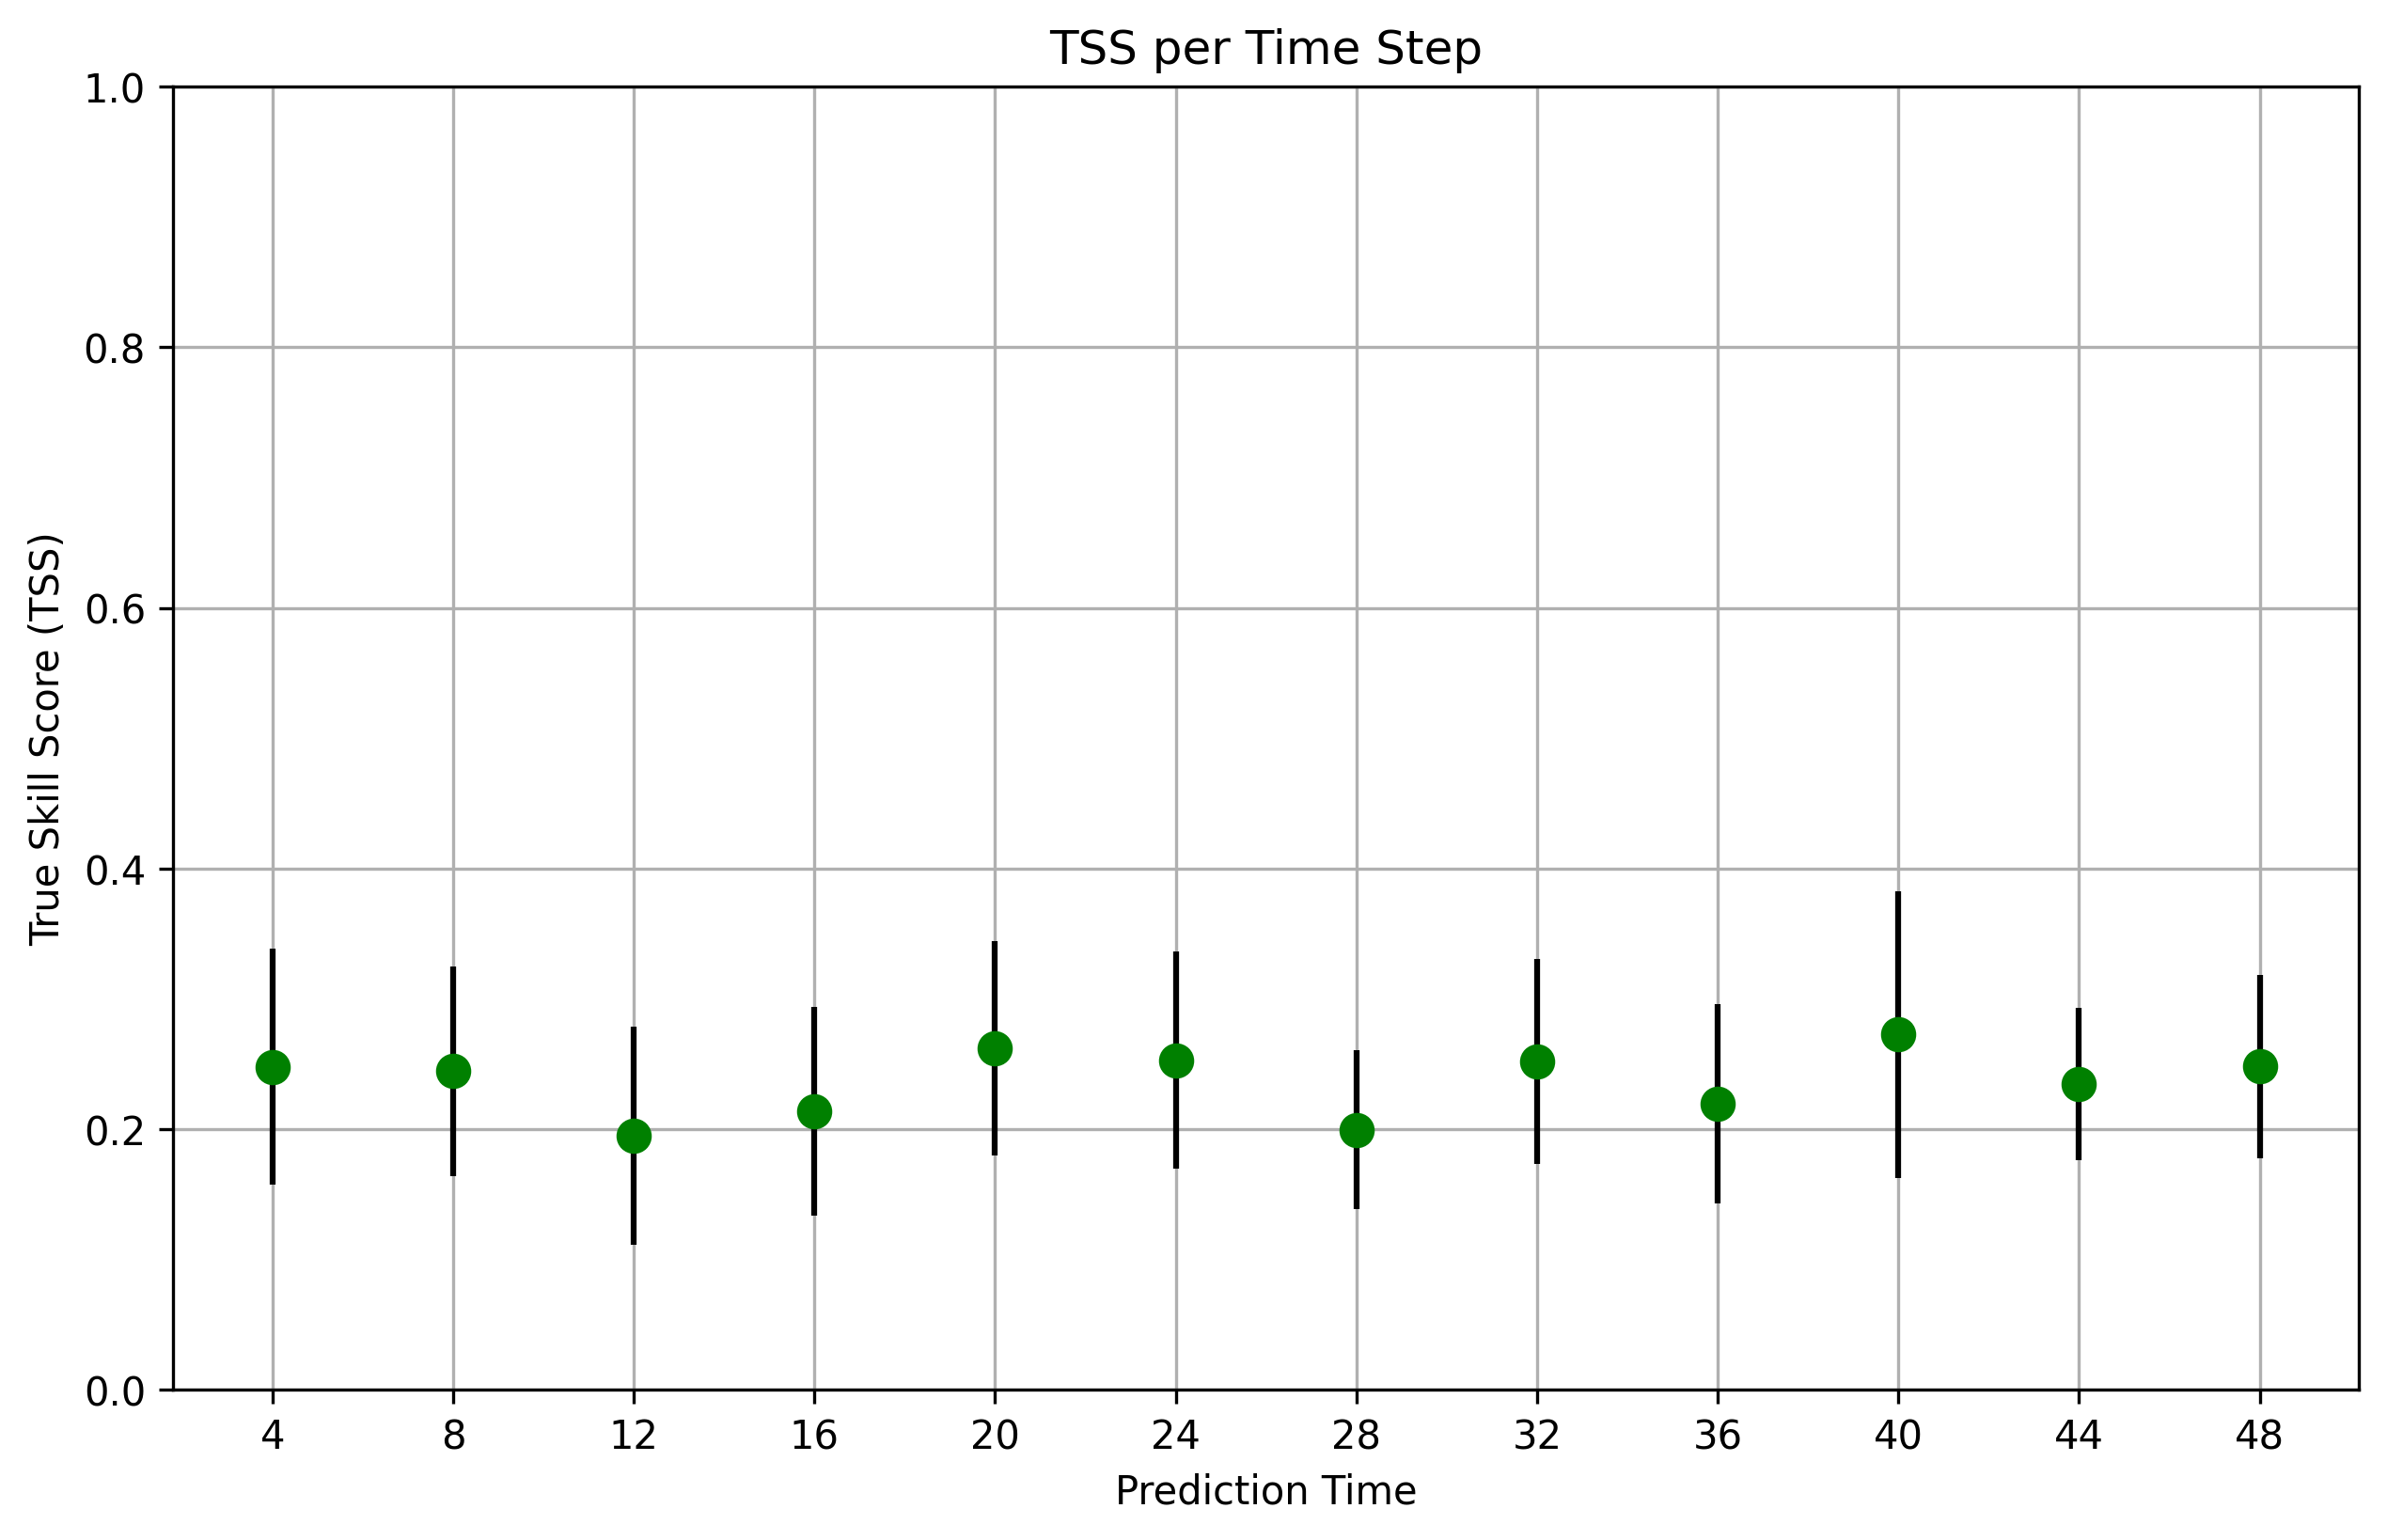

In [24]:
time_delta = range(4, 52, 4)

plt.figure(figsize=(10, 6), dpi=300)
plt.errorbar(time_delta, TSS_mean, yerr=TSS_std, fmt='o', c='black', markerfacecolor='green', markeredgecolor='green', markersize=8)
plt.xticks(time_delta)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xlabel('Prediction Time')
plt.ylabel('True Skill Score (TSS)')
plt.title('TSS per Time Step')
plt.grid(True)
plt.show()